<h1 align="center">Naive Bayes Classifier</h1>

Illustration of a Gaussian Naive Bayes classifier using the PIMA Indians Diabetes dataset.

This problem is comprised of 768 observations of medical details for Pima Indian patents. The records describe instantaneous measurements taken from the patient such as their age, the number of times pregnant and blood workup. All patients are women aged 21 or older. All attributes are numeric, and their units vary from attribute to attribute.

Each record has a class value that indicates whether the patient suffered an onset of diabetes within 5 years of when the measurements were taken (1) or not (0).

This is a standard dataset that has been studied a lot in machine learning literature. A good prediction accuracy is 70%-76%.

Attribute values are:

    1. Number of times pregnant
    2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    3. Diastolic blood pressure (mm Hg)
    4. Triceps skin fold thickness (mm)
    5. 2-Hour serum insulin (mu U/ml)
    6. Body mass index (weight in kg/(height in m)^2)
    7. Diabetes pedigree function
    8. Age (years)
    9. Class variable (0 or 1)

In [138]:
import pandas as pd
import numpy as np
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


d:\Anaconda3\envs\latest\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cm', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [139]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
data_df = pd.read_csv(data_url, header=None)

In [140]:
data_df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [141]:
# Assign names to columns
data_df.columns = ['n_pregnant', 'glucose_conc', 'diastolic_bp', 'skin_fold_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'has_diabetes']

In [142]:
# Make the target column string
data_df = data_df.assign(has_diabetes=data_df.has_diabetes.map(lambda v: 'yes' if v == 1 else 'no'))
data_df.head()

,n_pregnant,glucose_conc,diastolic_bp,skin_fold_thickness,insulin,bmi,diabetes_pedigree,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,yes
1,1,85,66,29,0,26.6,0.351,31,no
2,8,183,64,0,0,23.3,0.672,32,yes
3,1,89,66,23,94,28.1,0.167,21,no
4,0,137,40,35,168,43.1,2.288,33,yes


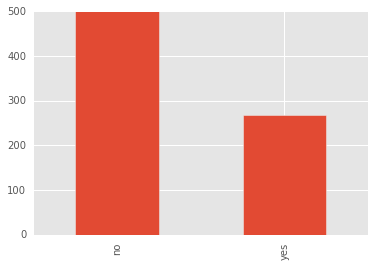

In [143]:
# Check for class imbalance
data_df.has_diabetes.value_counts().plot(kind='bar')

In [144]:
# Calculate class priors
priors = data_df.has_diabetes.value_counts(normalize=True)

In [145]:
priors

no     0.651042
yes    0.348958
Name: has_diabetes, dtype: float64

In [146]:
# Calculate mean and variance of each feature for each class
features = data_df.drop('has_diabetes', axis=1)
targets = data_df.has_diabetes

class_summaries = {} 
fg = features.groupby(targets)

for fname in features.columns:
    class_summaries[fname] = fg[fname].agg({'mean': np.mean, 'stddev': np.std})

In [147]:
class_summaries = pd.concat(class_summaries, axis=1)

In [148]:
class_summaries

age                  bmi            diabetes_pedigree  \
                 stddev       mean    stddev       mean            stddev   
has_diabetes                                                                
no            11.667655  31.190000  7.689855  30.304200          0.299085   
yes           10.968254  37.067164  7.262967  35.142537          0.372354   

                       diastolic_bp            glucose_conc              \
                  mean       stddev       mean       stddev        mean   
has_diabetes                                                              
no            0.429734    18.063075  68.184000    26.141200  109.980000   
yes           0.550500    21.491812  70.824627    31.939622  141.257463   

                 insulin             n_pregnant           skin_fold_thickness  \
                  stddev        mean     stddev      mean              stddev   
has_diabetes                                                                    
no             98.865289   68.792000   3.017185  3.298000           14.889947   
yes           138.689125  100.335821   3.741239  4.865672           17.679711   

                         
                   mean  
has_diabetes             
no            19.664000  
yes           22.164179

In [149]:
# Convert the mean/stddev combination into a Gaussian Distribution
from scipy.stats import norm

f_gaussians = {}

for fname in class_summaries.columns.get_level_values(0):
     f_gaussians[fname] = class_summaries.loc[:, fname].apply(lambda r: norm(loc=r['mean'], scale=r['stddev']), axis=1)


In [150]:
f_gaussians = pd.concat(f_gaussians, axis=1).T

In [151]:
f_gaussians

has_diabetes,no,yes
age,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
bmi,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
diabetes_pedigree,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
diastolic_bp,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
glucose_conc,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
insulin,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
n_pregnant,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
skin_fold_thickness,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...


In [152]:
# We can combine all the above into a class

class GaussianNB:
    
    def __init__(self):
        self._priors = None
        self._f_gaussians = None
        
    def fit(self, features, targets):
        """Calculate class priors and construct per feature per label Gaussian distributions."""
        self._priors = targets.value_counts(normalize=True)
        
        class_summaries = {} 
        fg = features.groupby(targets)

        for fname in features.columns:
            class_summaries[fname] = fg[fname].agg({'mean': np.mean, 'stddev': np.std}) 
        
        class_summaries = pd.concat(class_summaries, axis=1)
        
        f_gaussians = {}

        for fname in class_summaries.columns.get_level_values(0):
             f_gaussians[fname] = class_summaries.loc[:, fname].apply(
                     lambda r: norm(loc=r['mean'], scale=r['stddev']), axis=1)
                
        self._f_gaussians = pd.concat(f_gaussians, axis=1).T
        
    def _prob_for_one_label(self, f_row, label):
        """Calculate P(class|feature_values) for one feature row and one label"""
        label_prob = self._priors[label]       
        
        for f_name, norm_dist in self._f_gaussians[label].iteritems():
            label_prob *= norm_dist.pdf(f_row[f_name])
            
        return label_prob
    
    def _predict_one(self, f_row):
        """Calculate the predicted label for one feature."""
        all_label_probs = self._priors.index.map(lambda label: self._prob_for_one_label(f_row, label))
        return self._priors.index[np.argmax(all_label_probs)]
    
    def predict(self, features):
        """Calculate the predicted labels for a number of features."""
        predicted_labels = features.apply(self._predict_one, axis=1)
        return predicted_labels
    

In [153]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True)

results = []

for train_idx, test_idx in fold.split(features, targets):
    
    train_df, train_labels = features.iloc[train_idx], targets.iloc[train_idx]
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(train_df, train_labels)
    test_df, test_labels =  features.iloc[test_idx], targets.iloc[test_idx]
    predictions = gaussian_nb.predict(test_df)    
    
    fold_result = pd.DataFrame({'actual': test_labels, 'predicted': predictions})
    results.append(fold_result)
    

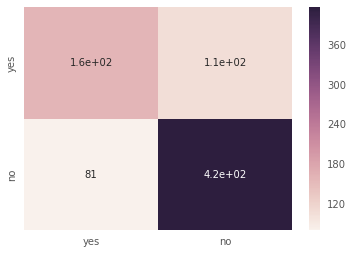

In [154]:
all_results = pd.concat(results, axis=0)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_results['actual'], all_results['predicted'], labels=['yes', 'no'])
cm_df = pd.DataFrame(cm, columns=['yes', 'no'], index=['yes', 'no'])

sns.heatmap(cm_df, annot=True)

In [155]:
accuracy = (all_results['actual'] == all_results['predicted']).sum() / len(all_results)

In [156]:
accuracy

0.75520833333333337